# **Capstone project: Providing data-driven suggestions for HR**

# **PACE stages**


#### 1) Plan:  understand your data in the problem context
#### 2) Analyze: EDA, check model assumptions & select model
#### 3) Construct: construct & evaluate model
#### 4) Plan: interpret model & share story

## **Pace: Plan**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

The goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If we can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### The HR dataset

The dataset contains 15,000 rows and 10 columns for the variables listed below. 


Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Key questions for the plan stage:
#### Who are the stakeholders for this project?: 
The stakeholders include the senior leadership team who has commissioned the report as well as the employees they seek to retain
#### What are we trying to solve or accomplish?
Predict whether an employee will leave the Company and understand why they leave. If Salifort could predict whether an employee will leave the company, and discover the reasons behind their departure, they could better understand the problem and develop a solution.  
#### What are the initial observations when exploring the data?
The data consists mostly of numbers, with the exception of department and salary data which are strings. The left feature, which is a target variable consists of both employees who choose to quit and those who are let go. Understanding why an employee leaves is just as important as predicting they will leave. For instance, retirement data is not as likely to be as actionable as data on undercompensation related turnover.
#### What resources can we use as we complete this stage?: <br>
- Google Advanced Data Analytics: https://www.coursera.org/professional-certificates/google-advanced-data-analytics
- SHRM Annual Job Satisfaction report: https://www.shrm.org/content/dam/en/shrm/topics-tools/news/hr-magazine/Employee-Job-Satisfaction-Engagement-Flyer.pdf
- Journal of Managerial Psychology: 'The Relationship Between Job Satisfaction and Job Tenure;' Sarker et al.
- McKinsey 'Why People are Quitting': https://www.mckinsey.com/featured-insights/themes/why-employees-are-quitting-and-what-to-do-about-it
- HBR 'Why People Quit Their Jobs': https://hbr.org/2016/09/why-people-quit-their-jobs
- Kaplan-Meier Estimator: https://en.wikipedia.org/wiki/Kaplan–Meier_estimator
- Lifelines: https://lifelines.readthedocs.io/en/latest/
- Survival Analysis in Python: https://www.analyticsvidhya.com/blog/2020/10/introduction-to-survival-analysis-lifelines-in-python/
- scikit-learn: https://scikit-learn.org/ 
- Gradient boosting: https://en.wikipedia.org/wiki/Gradient_boosting
- XGBoost: https://xgboost.readthedocs.io/en/stable/
- Optuna: https://github.com/optuna/optuna
- Kaggle: https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv

####  What are the ethical considerations at this stage?: <br>
Had the data been real I'd be concerned about handling and protecting PII, potential bias (eg response bias, convenience bias) in the survey results, cross-department evaluation consistency, and the implications of the analysis provided to senior leadership on both Salifort and its employees.

## Step 1. Imports & data loading


### Import packages

In [2]:
# install libraries

# optimized hyperparameter tuning w/ Optuna
!pip install optuna > /dev/null 2>&1  
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install ipython-autotime optuna > /dev/null 2>&1

# visualization readbility
!pip install tabulate > /dev/null 2>&1

# survival analysis w/ Kaplan-Meir non-parametric statistical testing
!pip install lifelines > /dev/null 2>&1 

In [3]:
# import packages for data manipulation
import numpy as np
import pandas as pd

# import packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance
from matplotlib.colors import LinearSegmentedColormap

# import packages for data preprocessing and statistical analysis
from sklearn.model_selection import train_test_split, cross_val_score
import scipy.stats as stats
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# import packages for data modeling
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution

# utilities
import time
import pickle
from pprint import pprint
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING) 

### Load dataset

`Pandas` is used to read a dataset called **`HR_capstone_dataset.csv`.**  As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [4]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2a. Data Exploration (Initial EDA and data cleaning)

### Gather basic information about the data

In [5]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [6]:
# Gather descriptive statistics about the data
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


### Rename columns

As a data cleaning step, we rename the columns as needed, standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [7]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [8]:
# Rename columns as needed
df0 = df0.rename(columns={'average_montly_hours': 'average_monthly_hours',
                          'Work_accident': 'work_accident',
                          'time_spend_company': 'tenure',
                          'promotion_last_5years': 'promoted_within5yrs',
                          'Department': 'department'
                         })


# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promoted_within5yrs', 'department', 'salary'],
      dtype='object')

### Check missing values

In [9]:
# Check for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promoted_within5yrs      0
department               0
salary                   0
dtype: int64

### Check duplicates

In [10]:
# Check for duplicates
duplicates = df0.duplicated().sum()
rows = df0.shape[0]
duplicates_pct = duplicates/rows
print(f'Number of duplicates: {duplicates}')
print(f'Number of rows: {rows}')
print(f'Percentage of duplicates: {duplicates_pct}')

Number of duplicates: 3008
Number of rows: 14999
Percentage of duplicates: 0.2005467031135409


In [11]:
# Inspect some rows containing duplicates as needed
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promoted_within5yrs,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


**Insights**:<br>
Its unlikely that there any two employees have the exact same response for every column, so its likely these are duplicates. Morevoer, there's ample sample size to continue the analysis. Therefore, we proceed to drop the duplicates.

In [12]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates()

### Check outliers

In [13]:
def outlier_detection(df):
    columns = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']
    results = pd.DataFrame(columns=['Lower Bound', 'Upper Bound', 'Outliers Count'])
    
    for col in columns:
        if col in ['satisfaction_level', 'last_evaluation']:
            lower_bound = max(0, df[col].quantile(0.01))
            upper_bound = min(1, df[col].quantile(0.99))
        elif col == 'average_monthly_hours':
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = max(0, mean - 3 * std)
            upper_bound = mean + 3 * std
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        results.loc[col] = [lower_bound, upper_bound, outliers]
    
    return results

In [14]:
outlier_results = outlier_detection(df1)
print("Outlier detection results:".center(50))
outlier_results

            Outlier detection results:            


,Lower Bound,Upper Bound,Outliers Count
satisfaction_level,0.100000,0.990000,210.0
last_evaluation,0.390000,1.000000,107.0
number_project,0.000000,8.000000,0.0
average_monthly_hours,54.290082,346.656961,0.0
tenure,1.500000,5.500000,824.0


Given the presence of outliers, we may remove them later as certain models aren't robust to handle outliers. But for now let's dig into tenure a bit further given the outliers

### Check statistics and general distribution

In [15]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,11991.0,0.629658,0.241070,0.09,0.48,0.66,0.82,1.0
last_evaluation,11991.0,0.716683,0.168343,0.36,0.57,0.72,0.86,1.0
number_project,11991.0,3.802852,1.163238,2.00,3.00,4.00,5.00,7.0
average_monthly_hours,11991.0,200.473522,48.727813,96.00,157.00,200.00,243.00,310.0
tenure,11991.0,3.364857,1.330240,2.00,3.00,3.00,4.00,10.0
work_accident,11991.0,0.154282,0.361234,0.00,0.00,0.00,0.00,1.0
left,11991.0,0.166041,0.372133,0.00,0.00,0.00,0.00,1.0
promoted_within5yrs,11991.0,0.016929,0.129012,0.00,0.00,0.00,0.00,1.0


# pAce: Analyze Stage



### Set an accessible color palette for charts

In [16]:
# setting a simple accessible visualization style
colors = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]
left_color = "#bc5090"
stayed_color = "#003f5c"

# set up the style
plt.style.use('seaborn')
sns.set_palette(colors)
sns.set(style='whitegrid')

# expand color theme as necessary for heatmap
custom_cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)

## Step 2b. Data Exploration (Continue EDA)

Let's begin exploring the tenure outliers.

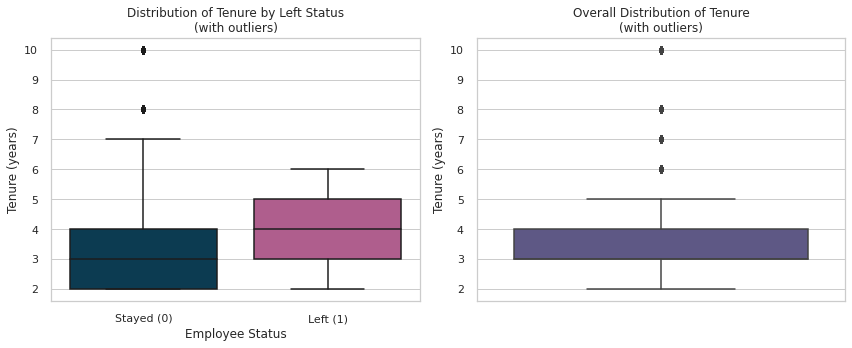

In [17]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# tenure distribution by left status
sns.boxplot(x='left', y='tenure', data=df1, palette={0: stayed_color, 1: left_color}, ax=ax1, showfliers=True)
ax1.set_title('Distribution of Tenure by Left Status\n(with outliers)', fontsize=12)
ax1.set_ylabel('Tenure (years)', fontsize=12)
ax1.set_xlabel('Employee Status', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Stayed (0)', 'Left (1)'])

# overall tenure distribution
sns.boxplot(y='tenure', data=df1, ax=ax2, color='#58508d', showfliers=True)
ax2.set_title('Overall Distribution of Tenure\n(with outliers)', fontsize=12)
ax2.set_ylabel('Tenure (years)', fontsize=12)
ax2.set_xlabel('')



# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Insight**:

- The first boxplot reveals an surprising insight: employees who left the company tend to have a longer median tenure than those who stayed. <br>
     <p></p>
- The distinction between "Stayed" and "Left" without considering tenure thresholds (e.g., staying for more than 2 years) could be misleading. Employees in the 0–2 year group who haven't left yet could be more at risk of leaving than the data currently shows, because early tenure turnover is common.<br>
<br>
- By mixing early-tenure employees with more tenured employees, we're not comparing apples to apples. An employee in the "Stayed" group with less than 1 year of tenure might still leave within the next year, so labeling them as "Stayed" creates a false sense of security.

To address this we will do three things:<br>
  a) separate the employees into cohortsof a tenure group using `KaplanMeirfFitter` survival analysis. This allows us to understand the nuance of EDA by tenure cohorts constructed to capture the periods that demarcate the noteceble changes in turnover; <br>
  <p></p>
  b) conduct KMeans as a preprocessing step to determine whether clusters of tenure + other feature make sense; <br>
  <p></p>
  c) birfurcate our model analysis by tenure and/or tenure clusters as might be indicated by KMeans.<br>
  

Let's start with separating employees into tenure groups to ensure we understand the mix and distribution of each beyond the labels provided.<br>

To estimate what might work as decent bins to capture turnover we will estimate the survival function using Kaplan-Meir survival analysis (KMSA).  KMSA handles that fact that employees in the 0-2 who havent left yet could still be at risk of leaving. KMSA calls this subjects who haven' had suffienct opportunity to go through an event _right censored data_. 

We can estimate the survival function of employee tenure, particularly in the context of employee turnover. This will help us understand the probability of an employee staying with the company over time and can reveal critical periods when employees are more likely to leave. Which in turn, allows us to establish tenure cohorts that make sense. 

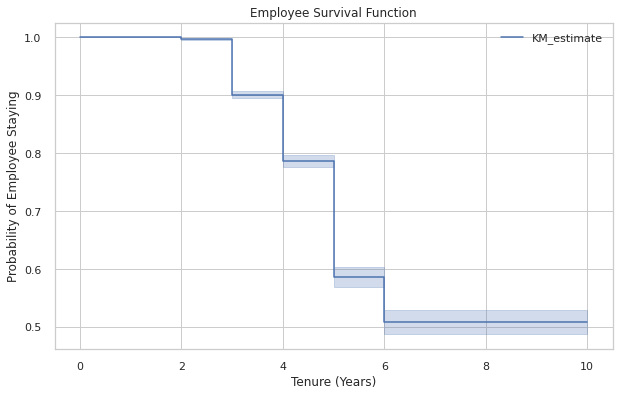

In [18]:
# instantiate KMF
kmf = KaplanMeierFitter()

# fit the model
kmf.fit(durations=df1['tenure'], event_observed=df1['left'])

# plot survival function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Employee Survival Function')
plt.xlabel('Tenure (Years)')
plt.ylabel('Probability of Employee Staying')
plt.show()

Now we can create tenure cohorts in a `tenure_group` that book end the steady states and capture each noticeable drop in probability of staying. This feature preprocessing step will likely make our analysis of most features more insightful.

In [19]:
# based on the chart above lets define tenure groups 0-2 and 6+ which bookend the steady state 
# and 2-4 and 4-6 which capture the noticeable drops in probability of staying
df1['tenure_group'] = pd.cut(df1['tenure'], bins=[0, 2, 4, 6, 10], labels=['0-2', '2-4', '4-6', '6+'])

# an inverted order of tenure group for increased chart readability
inverted_tenure = ['6+', '4-6', '2-4', '0-2']

In [20]:
# explore the  # and % of people who left vs. stayed
counts = df1['left'].value_counts().sort_index()
pcts = df1['left'].value_counts(normalize=True).sort_index()

median_tenure = df1.groupby('left')['tenure'].median().sort_index()

left_df = pd.DataFrame({
    '#': counts,
    '%': pcts,
    'Median Tenure': median_tenure
})

left_df['%'] = left_df['%'].round(2)
left_df['Median Tenure'] = left_df['Median Tenure'].round(2)
left_df = left_df.rename(index={0: 'Stayed', 1: 'Left'})
left_df = left_df.reindex(['Left', 'Stayed'])

print('\nLeft vs. Stayed Count and Percentage:')
print(tabulate(left_df, headers='keys', tablefmt='rounded_grid'))

# count employees in each cohort by left status 
tenure_group_counts = df1.groupby(['tenure_group', 'left']).size().unstack(fill_value=0)
tenure_group_counts.columns = ['Stayed_#', 'Left_#']

# calculate percents
total_stayed = tenure_group_counts['Stayed_#'].sum()
total_left = tenure_group_counts['Left_#'].sum()
result_df = tenure_group_counts.copy()
result_df['Stayed_%'] = (result_df['Stayed_#'] / total_stayed * 100).round(2)
result_df['Left_%'] = (result_df['Left_#'] / total_left * 100).round(2)

# reorder columns
result_df = result_df[['Left_#', 'Left_%','Stayed_#', 'Stayed_%']]

# total row
total_row = pd.DataFrame({
    'Stayed_#': [total_stayed],
    'Stayed_%': [100.00],
    'Left_#': [total_left],
    'Left_%': [100.00]
}, index=['Total'])

result_df = pd.concat([result_df, total_row])

print('\nLeft vs Stay Tenure Group Cohort Analysis:')
print(tabulate(result_df, headers='keys', tablefmt='rounded_grid'))


Left vs. Stayed Count and Percentage:
╭────────┬───────┬──────┬─────────────────╮
│        │     # │    % │   Median Tenure │
├────────┼───────┼──────┼─────────────────┤
│ Left   │  1991 │ 0.17 │               4 │
├────────┼───────┼──────┼─────────────────┤
│ Stayed │ 10000 │ 0.83 │               3 │
╰────────┴───────┴──────┴─────────────────╯

Left vs Stay Tenure Group Cohort Analysis:
╭───────┬──────────┬──────────┬────────────┬────────────╮
│       │   Left_# │   Left_% │   Stayed_# │   Stayed_% │
├───────┼──────────┼──────────┼────────────┼────────────┤
│ 0-2   │       31 │     1.56 │       2879 │      28.79 │
├───────┼──────────┼──────────┼────────────┼────────────┤
│ 2-4   │     1369 │    68.76 │       5826 │      58.26 │
├───────┼──────────┼──────────┼────────────┼────────────┤
│ 4-6   │      591 │    29.68 │       1013 │      10.13 │
├───────┼──────────┼──────────┼────────────┼────────────┤
│ 6+    │        0 │     0    │        282 │       2.82 │
├───────┼──────────┼─────────

**Insights**:
- The median tenure of those that have 'left' is 4 years whereas, the median tenure of those that have stayed is only 3 years. Based on the cohort analysis its clear that there is noticeable dropoff in Tenure employees after year 2 and again after year 4. With finer grained bins we can determine the distribution with more precision, but this is directionally sufficient for now. <br>
<p></p>
- Survivorship Bias: The lower median tenure for current employees doesn't necessarily indicate a problem. It could reflect:<br>
     a) Recent company growth and hiring<br>
     b) A survivorship bias where longer-tenured employees who left are compared against a mix of new and long-term current employees
     <p></p>
- Turnover Dynamics: The higher median tenure for former employees suggests that: <br>
  a) The company retains a portion of employees for a considerable time<br>
  b) There might be factors causing experienced employees to leave after several years
   <p></p>
- While there is a moderate imbalance in the target class (83% vs 17%), its not severe enough to warrant upsampling (eg SMOTE)

### Data visualizations: continuous and discrete features

First, we'll create a reusable function to explore continuous and discrete features. 
- Histograms and boxplots quickly visualize  distribution of the features, split by left status. 
- The boxplot allows us to identify any differences across cohort from the tenure group (see `tenure_group` above)
- We calculate mean and median statistics to quantify the central tendencies for each groupand 
- A Mann-Whitney U test (MWU)to assess whether there's a significant difference in the feature's values by left status. The MWU is used as it doesn't assume normality and we have some clearly non-normal distributions (eg `number_project`). 

In [21]:
def analyze_feature(df, feature_name, feature_title):
    # plots for histogram and boxplot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # histogram
    sns.histplot(data=df, x=feature_name, hue='left', kde=True, element='step',
                 palette={0: stayed_color, 1: left_color}, ax=ax[0])
    ax[0].set_title(f'Distribution of {feature_title} by Employee Status')
    ax[0].set_xlabel(feature_title)
    ax[0].set_ylabel('Employee Count')
    ax[0].legend(title='Left', labels=['Stayed', 'Left'])
    
    # boxplot
    sns.boxplot(data=df, x=feature_name, y='tenure_group', hue='left',
                palette={0: stayed_color, 1: left_color},
                ax=ax[1], order=inverted_tenure)
    ax[1].set_title(f'{feature_title} by Tenure')
    ax[1].set_xlabel(feature_title)
    ax[1].set_ylabel('Tenure (Years)')
    ax[1].legend(title='Left', loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # calculate mean and median
    mean_median = df.groupby('left')[feature_name].agg(['mean', 'median'])
    mean_median.index=['Stayed', 'Left']
    print(f'\n{feature_title} Statistics:')
    print(tabulate(mean_median.round(3), headers='keys', tablefmt='rounded_grid'))
    
    # statistical Test
    stat, p_value = stats.mannwhitneyu(df[df['left'] == 0][feature_name],
                                       df[df['left'] == 1][feature_name])
    fmt_stat = f"{stat:.2f}"
    fmt_p_value = f"{p_value:.4e}"
    
    # output the result
    mann_whitney_results = pd.DataFrame({
        'Statistic': [fmt_stat],
        'p-value': [fmt_p_value]
    }, index=['Mann-Whitney U'])
    print(f'\nMann-Whitney U Test of {feature_title} Difference Significance:')
    print(tabulate(mann_whitney_results, headers='keys', tablefmt='rounded_grid'))

We'll start with `satisfaction_level` as we might expect to see patterns there.

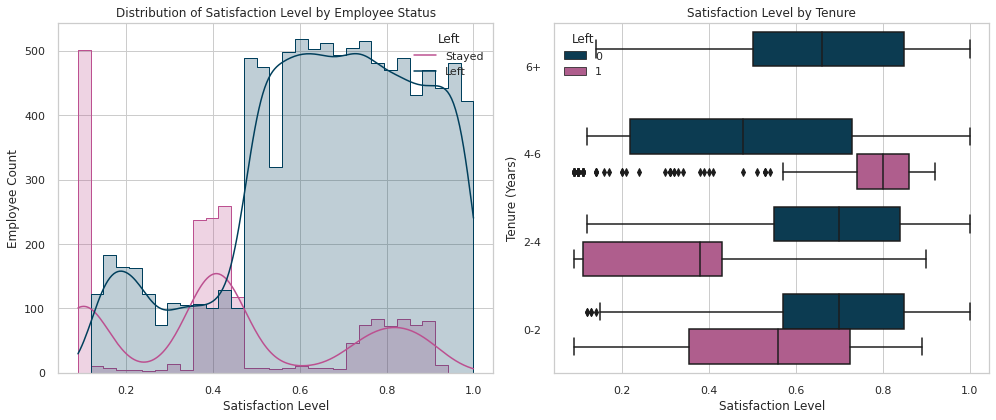


Satisfaction Level Statistics:
╭────────┬────────┬──────────╮
│        │   mean │   median │
├────────┼────────┼──────────┤
│ Stayed │  0.667 │     0.69 │
├────────┼────────┼──────────┤
│ Left   │  0.44  │     0.41 │
╰────────┴────────┴──────────╯

Mann-Whitney U Test of Satisfaction Level Difference Significance:
╭────────────────┬─────────────┬─────────────╮
│                │   Statistic │     p-value │
├────────────────┼─────────────┼─────────────┤
│ Mann-Whitney U │ 5.03706e+06 │ 1.1201e-266 │
╰────────────────┴─────────────┴─────────────╯


In [22]:
analyze_feature(df1, 'satisfaction_level', 'Satisfaction Level')

**Insights**:
- **Satisfaction Levels**: Employees who left had significantly lower satisfaction levels compared to those who stayed. The average satisfaction of those who left was 0.44, while it was 0.67 for those who stayed, suggesting dissatisfaction is a key predictor of turnover.
<p></p>
- **Distribution & Tenure**: When breaking down by tenure however we get more nuance behind the relationship which ends up looking similar to a U-shape where satisfaction declines and then increases as tenure increases. This U-shaped pattern has been noted in other studies such as **"The Relationship Between Job Satisfaction and Job Tenure"**; Sarker, Saptarshi Jyoti; Crossman, Alf; Chinmeteepituck, Parkpoom; Journal of Managerial Psychology (2003) <br>
    a) For shorter tenures (0-2 years and 2-4 years), employees who left indeed show lower satisfaction levels compared to those who stayed .<br>
    b) However, for longer tenures (4-6 years and 6+ years), this pattern changes: In the 4-6 year group, the satisfaction levels of those who left are higher than those who stayed. In the 6+ year group, only those who stayed are represented, suggesting very few departures among long-tenured employees.<br>
   c) There's a trend of increasing satisfaction with tenure for those who stayed, while the pattern seems drop then increase the longer those who left, stayed.
<p></p>
- **Statistical Significance**: The MWU test test confirms a highly significant difference in satisfaction levels between employees who stayed and left, indicating that satisfaction is a strong predictor of turnover at Salifort.


Next we'll analyze `average_monthly_hours`

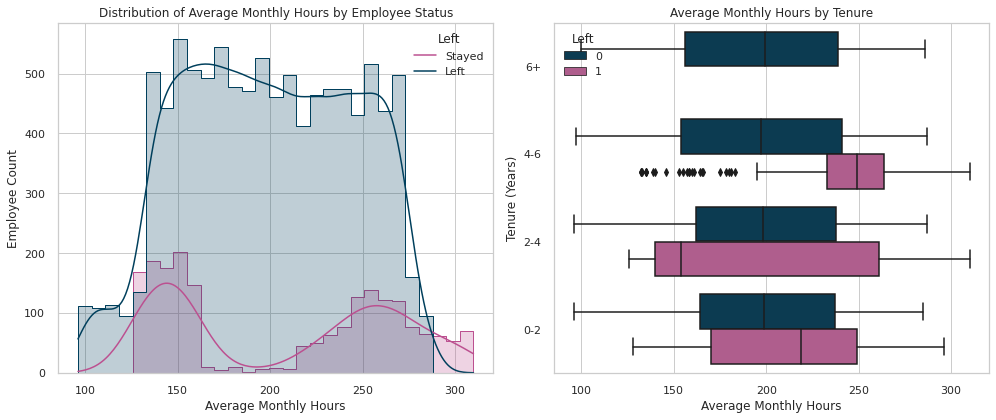


Average Monthly Hours Statistics:
╭────────┬─────────┬──────────╮
│        │    mean │   median │
├────────┼─────────┼──────────┤
│ Stayed │ 198.943 │      198 │
├────────┼─────────┼──────────┤
│ Left   │ 208.162 │      226 │
╰────────┴─────────┴──────────╯

Mann-Whitney U Test of Average Monthly Hours Difference Significance:
╭────────────────┬─────────────┬───────────╮
│                │   Statistic │   p-value │
├────────────────┼─────────────┼───────────┤
│ Mann-Whitney U │ 9.21933e+06 │ 9.162e-08 │
╰────────────────┴─────────────┴───────────╯


In [23]:
analyze_feature(df1, 'average_monthly_hours', 'Average Monthly Hours')

**Insights**:
- **Average Hours**: Employees who left worked, on average, more hours per month (208 hrs) compared to those who stayed (198 hrs). This suggests that overwork could be a contributing factor to turnover.
<p></p>

- **Trend Across Tenure**: Our previous outlier detection (see **Check Outliers**) indicated no outliers in average monthly hours. Breaking cohorts down in tenure_group, indicate that there are outliers,especially in the 4-6 year group, indicating on average, those that leave work harder during this period, but that some might have checked out at this point and work below avearage hours.  Across tenure cohorts, those who left had higher average monthly hours, especially in the mid-tenure range (2-4 and 4-6 years), reinforcing that employees in these stages may feel overworked or burnt out, leading to increased departures.
<p></p>
- **Statistical Significance**: The MWU test also shows a significant difference between the two groups for average monthly hours (p < 0.0001), indicating that work hours are a relevant factor in predicting turnover at Salifort.


Since it might be related we'll take a look at `number_project` next.

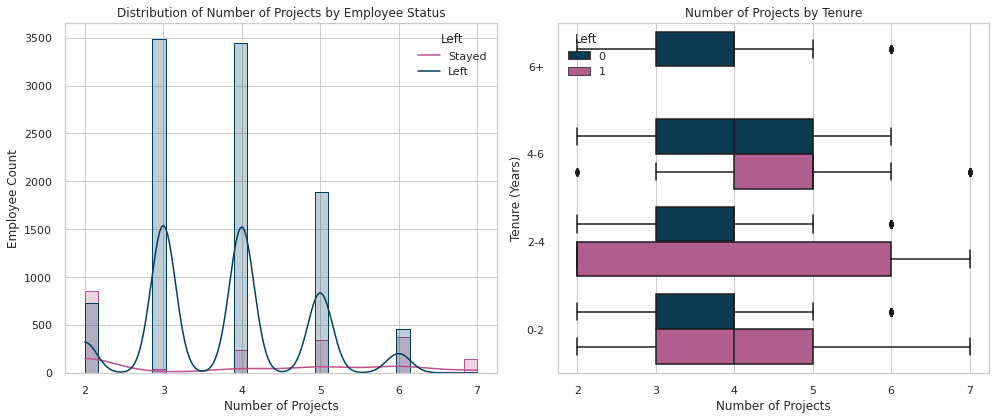


Number of Projects Statistics:
╭────────┬────────┬──────────╮
│        │   mean │   median │
├────────┼────────┼──────────┤
│ Stayed │  3.787 │        4 │
├────────┼────────┼──────────┤
│ Left   │  3.883 │        4 │
╰────────┴────────┴──────────╯

Mann-Whitney U Test of Number of Projects Difference Significance:
╭────────────────┬─────────────┬───────────╮
│                │   Statistic │   p-value │
├────────────────┼─────────────┼───────────┤
│ Mann-Whitney U │ 9.83542e+06 │   0.19051 │
╰────────────────┴─────────────┴───────────╯


In [24]:
analyze_feature(df1, 'number_project', 'Number of Projects')

**Insights**:
- **Project number**: There is no significant difference in the number of projects handled by employees who stayed  (3.79) and those who left (3.88). The median is the same (4 projects for both groups), suggesting that the number of projects is not a key factor in employee turnover.
<p></p>
- **Trend across Tenure**: The data shows no clear trends in turnover by the number of projects across different tenure groups.
<p></p>
- **Statistical Significance**: The MWU shows a non-significant difference in the number of projects between those who stayed and those who left (p = 0.19), implying that project workload is not a differentiating factor.


Next we'll analyze `last_evaluation`

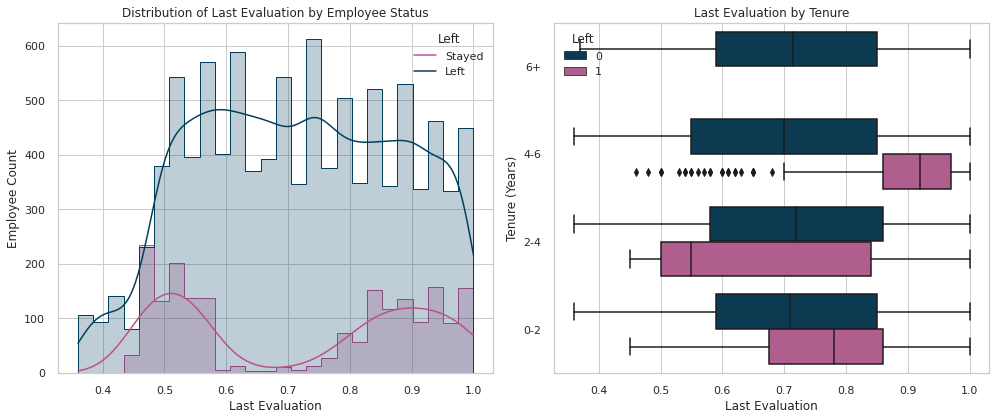


Last Evaluation Statistics:
╭────────┬────────┬──────────╮
│        │   mean │   median │
├────────┼────────┼──────────┤
│ Stayed │  0.716 │     0.71 │
├────────┼────────┼──────────┤
│ Left   │  0.722 │     0.79 │
╰────────┴────────┴──────────╯

Mann-Whitney U Test of Last Evaluation Difference Significance:
╭────────────────┬─────────────┬───────────╮
│                │   Statistic │   p-value │
├────────────────┼─────────────┼───────────┤
│ Mann-Whitney U │ 9.86596e+06 │   0.26392 │
╰────────────────┴─────────────┴───────────╯


In [25]:
analyze_feature(df1, 'last_evaluation', 'Last Evaluation')

**Insights**
- **Key Insight on Turnover**: There is a small, non-significant difference in the last evaluation scores between employees who stayed (mean 0.72) and those who left (mean 0.72). This suggests that performance evaluations alone are not predictive of turnover.
<p></p>
- **Trend Across Tenure**: The relationship between evaluation scores and tenure does not show clear patterns to explain turnover, indicating that evaluations may not correlate with leaving or staying
<p></p>
- **Statistical Significance**: The MWU shows no significant difference in last evaluation scores between those who stayed and those who left (p = 0.26), further supporting the lack of a strong relationship.

### Data visualizations: binary features

Now we'll move on to analyzing the binary variables.
- Bar plots are used show the proportion of employees by left status for each category of binary feature to see it either is associated with higher turnover.
- The second barplot shows how the proportion of the binary feature varies across tenure groups and employee status. This uncovers potential interactions between tenure,we've identified as crucial (to identify patterns over time), the feature and turnover. 
- Chi-squared tests of independence are chosen for binary data, as theyre useful for assessing whether there's statistical significance between two categorical variables - in this case, the binary feature and the binary 'left' status.<br>

Since the optimal visualizations are different, we first define a helpful function to add labels to the charts in way thats readable.



In [26]:
def add_labels(ax, fontsize=11):
    """
    add labels to the bars in a bar plot if height is >= 1% and above.
    params: ax: The matplotlib axes object containing the bar plot.
    """
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        # check for finite values
        if not (np.isfinite(x) and np.isfinite(y) and np.isfinite(width) and np.isfinite(height)):
            continue
        if height <= 0:
            continue  
        percentage = f'{height:.0%}'
        if height >= 0.01:
            # label inside the bar
            ax.text(x + width / 2, y + height / 2,
                    percentage, ha='center', va='center', fontsize=fontsize, color='white')
        else:
            # label above the bar in black
            ax.text(x + width / 2, y + height + 0.005,
                    percentage, ha='center', va='bottom', fontsize=fontsize, color='black')

Next we build the function to visualize binary features `promoted_within5yrs` and `work_accident`

In [27]:
def analyze_binary_feature(df, feature_name, feature_title):
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # counts the number of occurrences for each combination of the binary feature and the 'left' status
    contingency = pd.crosstab(df[feature_name], df['left'])
    contingency_percent = contingency.div(contingency.sum(axis=1), axis=0)
    contingency_percent.index = contingency_percent.index.map({0: 'No', 1: 'Yes'})

    # stacked bar plot of overall percentages 
    contingency_percent.plot(kind='bar', stacked=True,
                             color=[stayed_color, left_color], ax=ax[0])

    ax[0].set_title(f'Percentage of Employee Status by {feature_title}')
    ax[0].set_xlabel(feature_title)
    ax[0].set_ylabel('Proportion')
    ax[0].legend(title='Left', labels=['Stayed', 'Left'])

    # label adding 
    add_labels(ax[0])

    # group by 'tenure_group' and 'left', calculate mean of the binary feature
    group_data = df.groupby(['tenure_group', 'left'])[feature_name].mean().reset_index(name='proportion')
    group_data['Left Status'] = group_data['left'].map({0: 'Stayed', 1: 'Left'})

    # order 'tenure_group' correctly
    group_data['tenure_group'] = pd.Categorical(group_data['tenure_group'], categories=inverted_tenure[::-1], ordered=True)

    # bar chart of proportions by tenure group 
    sns.barplot(data=group_data, x='tenure_group', y='proportion', hue='Left Status',
                palette={'Stayed': stayed_color, 'Left': left_color}, ax=ax[1], order=inverted_tenure[::-1])

    ax[1].set_title(f'Proportion of {feature_title} by Tenure and Left Status')
    ax[1].set_xlabel('Tenure Group (Years)')
    ax[1].set_ylabel(f'Proportion with {feature_title}')
    ax[1].legend(title='Left', loc='upper left')

    # conditional label adding 
    add_labels(ax[1])

    plt.tight_layout()
    plt.show()

    # calculate useful stats
    counts = contingency.copy()
    counts.index = counts.index.map({0: 'No', 1: 'Yes'})
    counts.columns = counts.columns.map({0: 'Stayed', 1: 'Left'})

    print(f'\n{feature_title} Counts:')
    print(tabulate(counts, headers='keys', tablefmt='rounded_grid'))

    # statistical Test: Chi-squared test of independence
    stat, p_value, dof, expected = stats.chi2_contingency(contingency)
    fmt_stat = f"{stat:.2f}"
    fmt_p_value = f"{p_value:.4e}"

    # chi-squared results
    chi2_results = pd.DataFrame({
        'Statistic': [fmt_stat],
        'p-value': [fmt_p_value],
        'Degrees of Freedom': [dof]
    }, index=['Chi-squared Test'])

    print(f'\nChi-squared Test of Independence between {feature_title} and Left Status:')
    print(tabulate(chi2_results, headers='keys', tablefmt='rounded_grid'))

Next we call the function to analyze `promoted_within5yrs` and how its relationship changes with the different cohorts in `tenure_group`

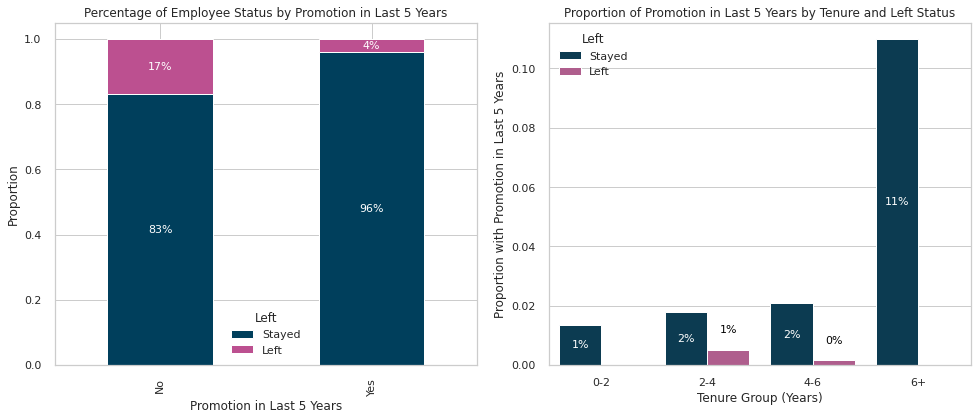


Promotion in Last 5 Years Counts:
╭───────────────────────┬──────────┬────────╮
│ promoted_within5yrs   │   Stayed │   Left │
├───────────────────────┼──────────┼────────┤
│ No                    │     9805 │   1983 │
├───────────────────────┼──────────┼────────┤
│ Yes                   │      195 │      8 │
╰───────────────────────┴──────────┴────────╯

Chi-squared Test of Independence between Promotion in Last 5 Years and Left Status:
╭──────────────────┬─────────────┬────────────┬──────────────────────╮
│                  │   Statistic │    p-value │   Degrees of Freedom │
├──────────────────┼─────────────┼────────────┼──────────────────────┤
│ Chi-squared Test │       22.99 │ 1.6267e-06 │                    1 │
╰──────────────────┴─────────────┴────────────┴──────────────────────╯


In [28]:
analyze_binary_feature(df1, 'promoted_within5yrs', 'Promotion in Last 5 Years')

**Insights**:
- **Promoted within last 5 years**: Very few employees who left (only 0.4%) were promoted within the last 5 years, compared to 1.9% of those who stayed suggesting lack of promotion may be contributing to turnover.
<p></p>
- **Trend Across Tenure**: Employees that have stayed for over 6 years are much more likely to be promoted (11%), but those who left within this group were not promoted. This implies that promotion may be a key retention factor for employees that have been there longer.
<p></p>
- **Statistical Significance**: The Chi-squared test confirms a significant association between promotion status and employee turnover, suggesting that the lack of promotion is correlated with employees leaving the company.

Next we'll explore `work_accident` and its relationship with `tenure_group`

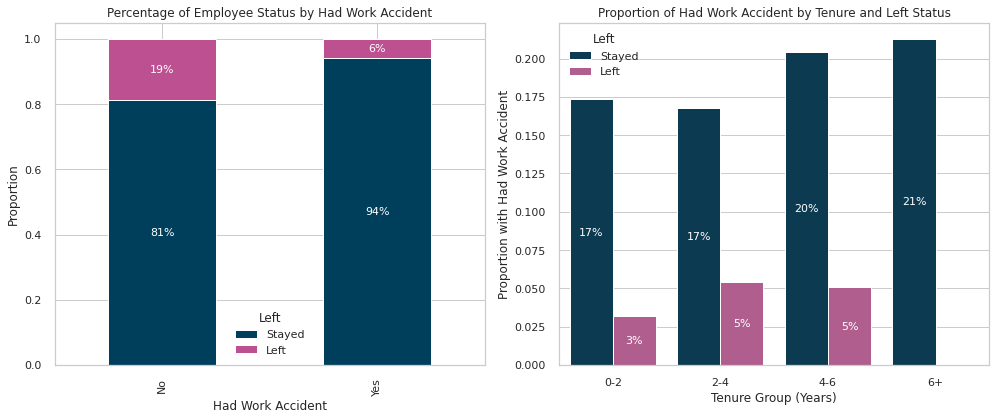


Had Work Accident Counts:
╭─────────────────┬──────────┬────────╮
│ work_accident   │   Stayed │   Left │
├─────────────────┼──────────┼────────┤
│ No              │     8255 │   1886 │
├─────────────────┼──────────┼────────┤
│ Yes             │     1745 │    105 │
╰─────────────────┴──────────┴────────╯

Chi-squared Test of Independence between Had Work Accident and Left Status:
╭──────────────────┬─────────────┬────────────┬──────────────────────╮
│                  │   Statistic │    p-value │   Degrees of Freedom │
├──────────────────┼─────────────┼────────────┼──────────────────────┤
│ Chi-squared Test │      187.74 │ 9.9112e-43 │                    1 │
╰──────────────────┴─────────────┴────────────┴──────────────────────╯


In [29]:
analyze_binary_feature(df1, 'work_accident', 'Had Work Accident')

**Insights**:
- **Work accident**: Employees who had a work accident were more likely to leave (6%) compared to those who stayed (19% of those who left experienced an accident vs. 17% of those who stayed). While work accidents are common, the fact that those who experienced accidents had a higher turnover rate suggests accidents might contribute to turnover.
<p></p>
- **Trend Across Tenure**:  Interestingly, the proportion of work accidents is highest for employees with longer tenure (4-6 years, 6+ years), which suggests that the company’s more experienced employees are experiencing accidents at a high rate. However, the proportion of employees leaving after an accident does not increase significantly across tenure groups, implying that accidents may be a factor regardless of tenure.
<p></p>
- **Statistical Significance**: The Chi-squared test shows a highly significant relationship (9.9112e-43) between work accidents and turnover, indicating that work accidents are indeed associated with a higher likelihood of leaving.

### Data visualizations: categorical features

For visualization, we create a reusable function to createe a barchart and heatmap to display the proportion of employees who left within each combo of the categorical feature and tenure group. With this we might be able to visualize:

- Patterns Across Tenure Groups: to see how turnover rates vary with tenure for each category
- Comparisons Between Categories: to identify categories where turnover is particularly high or low for certain tenure groups
- Intensity of Turnover: The color intensity represents the proportion of employees who left, making it easy to spot significant areas

Again, the chi-squared test is used as it can handle categorical variables with multiple levels and helps determine if there's statistical significance between the categorical feature and turnover. 

In [30]:
def analyze_categorical_feature(df, feature_name, feature_title):
    # ensure feature is of type 'category'
    df[feature_name] = df[feature_name].astype('category')

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # stacked bar chart of overall percentages
    contingency = pd.crosstab(df[feature_name], df['left'])
    contingency_percent = contingency.div(contingency.sum(axis=1), axis=0)
    contingency_percent.plot(kind='bar', stacked=True,
                             color=[stayed_color, left_color],width=0.9, ax=ax[0])


    ax[0].set_title(f'Left Status by {feature_title}')
    ax[0].set_xlabel(feature_title)
    ax[0].set_ylabel('Proportion')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax[0].legend(title='Left', labels=['Stayed', 'Left'], loc='upper center',
                 bbox_to_anchor=(0.75, -0.15), ncol=2)

    # add labels 
    add_labels(ax[0])

    # calculate the proportion of employees who left within each combination
    heatmap_data = df.groupby([feature_name, 'tenure_group'])['left'].mean().reset_index()
    heatmap_pivot = heatmap_data.pivot(index='tenure_group', columns=feature_name, values='left')

    # order correctly
    heatmap_pivot = heatmap_pivot.reindex(index=inverted_tenure)

    # heatmap
    sns.heatmap(heatmap_pivot, annot=True, fmt=".0%", cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Turnover Rate'}, ax=ax[1])

    ax[1].set_title(f'Turnover Rate by {feature_title} and Tenure Group')
    ax[1].set_xlabel(feature_title)
    ax[1].set_ylabel('Tenure Group (Years)')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    plt.tight_layout()
    plt.show()

    # contingency table
    counts = contingency.copy()
    counts.columns = counts.columns.map({0: 'Stayed', 1: 'Left'})

    print(f'\n{feature_title} Counts:')
    print(tabulate(counts, headers='keys', tablefmt='rounded_grid'))

    # statistical test: Chi-squared test of independence
    stat, p_value, dof, expected = stats.chi2_contingency(contingency)
    fmt_stat = f"{stat:.2f}"
    fmt_p_value = f"{p_value:.4e}"

    # chi-squared result to df
    chi2_results = pd.DataFrame({
        'Statistic': [fmt_stat],
        'p-value': [fmt_p_value],
        'Degrees of Freedom': [dof]
    }, index=['Chi-squared Test'])

    print(f'\nChi-squared Test of Independence between {feature_title} and Left Status:')
    print(tabulate(chi2_results, headers='keys', tablefmt='rounded_grid'))

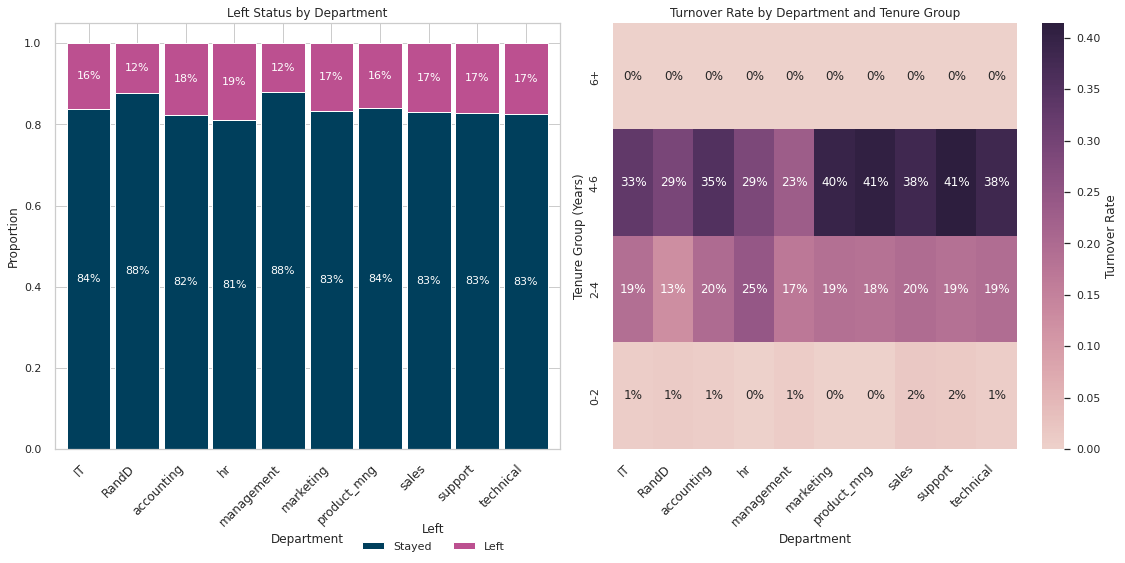


Department Counts:
╭──────────────┬──────────┬────────╮
│ department   │   Stayed │   Left │
├──────────────┼──────────┼────────┤
│ IT           │      818 │    158 │
├──────────────┼──────────┼────────┤
│ RandD        │      609 │     85 │
├──────────────┼──────────┼────────┤
│ accounting   │      512 │    109 │
├──────────────┼──────────┼────────┤
│ hr           │      488 │    113 │
├──────────────┼──────────┼────────┤
│ management   │      384 │     52 │
├──────────────┼──────────┼────────┤
│ marketing    │      561 │    112 │
├──────────────┼──────────┼────────┤
│ product_mng  │      576 │    110 │
├──────────────┼──────────┼────────┤
│ sales        │     2689 │    550 │
├──────────────┼──────────┼────────┤
│ support      │     1509 │    312 │
├──────────────┼──────────┼────────┤
│ technical    │     1854 │    390 │
╰──────────────┴──────────┴────────╯

Chi-squared Test of Independence between Department and Left Status:
╭──────────────────┬─────────────┬───────────┬─────────────

In [31]:
analyze_categorical_feature(df1, 'department', 'Department')

**Insights**:
- **Department**: EThe turnover rate appears to be relatively consistent across departments, with 16-19% of employees leaving across most departments. 
<p></p>
- **Trend Across Tenure**:  Employees in the 2-4 year tenure group show the highest turnover rates across most departments, particularly in sales, support, and technical departments where turnover reaches 40-41%. However, no employees with 6+ years of tenure left across any department, indicating strong retention once employees pass the 6 year mark
<p></p>
- **Statistical Significance**: The Chi-squared test (p = 0.013) shows a significant association between department and turnover, although the effect size appears moderate given the similar turnover rates across departments.

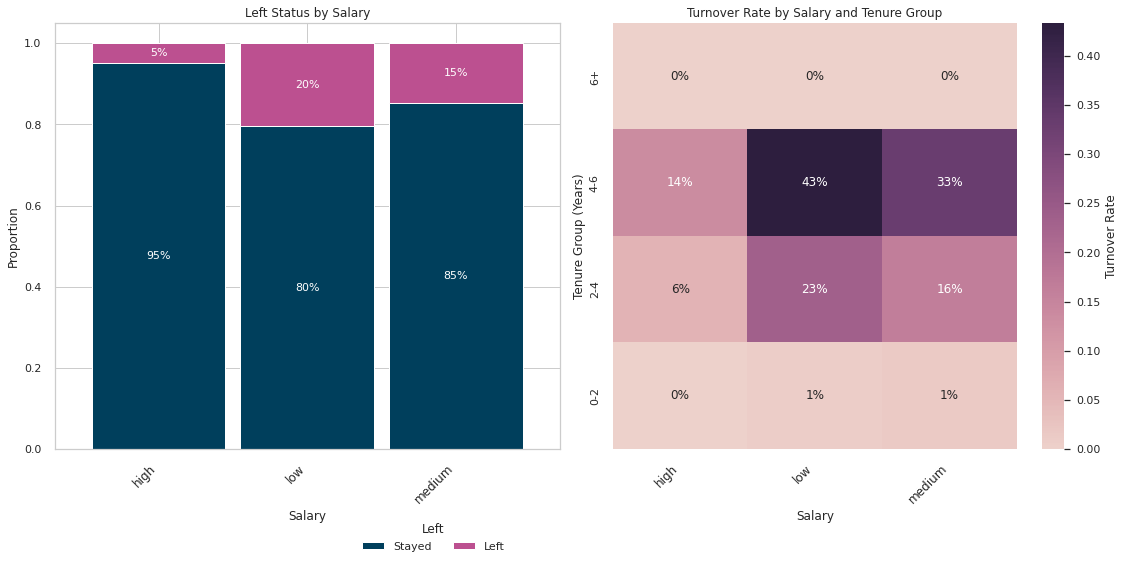


Salary Counts:
╭──────────┬──────────┬────────╮
│ salary   │   Stayed │   Left │
├──────────┼──────────┼────────┤
│ high     │      942 │     48 │
├──────────┼──────────┼────────┤
│ low      │     4566 │   1174 │
├──────────┼──────────┼────────┤
│ medium   │     4492 │    769 │
╰──────────┴──────────┴────────╯

Chi-squared Test of Independence between Salary and Left Status:
╭──────────────────┬─────────────┬────────────┬──────────────────────╮
│                  │   Statistic │    p-value │   Degrees of Freedom │
├──────────────────┼─────────────┼────────────┼──────────────────────┤
│ Chi-squared Test │      175.21 │ 8.9841e-39 │                    2 │
╰──────────────────┴─────────────┴────────────┴──────────────────────╯


In [32]:
analyze_categorical_feature(df1, 'salary', 'Salary')

**Insights**:
- **Salary**: Employees with low salaries are far more likely to leave (20%) than those with medium (15%) or high salaries (5%). This suggests that salary is a strong predictor of employee turnover.
<p></p>
- **Trend Across Tenure**:  The 4-6 year tenure group shows the highest turnover rate for low and medium salary employees, reaching 43% for low-salary workers. This reinforces that mid-tenure employees who are undercompensated are most at risk of leaving.
<p></p>
- **Statistical Significance**: The Chi-squared test (p < 0.0001) confirms a highly significant relationship between salary and turnover, indicating that salary levels have a substantial effect on the likelihood of an employee leaving.

### Data visualizations: multivariate survial analysis, interaction and correlation of features

Next we run a pairplot to get insight into relationships between multiple variables simultaneously, which can reveal non-linear patterns or interactions that the CoxPHFitter's linear model might miss.

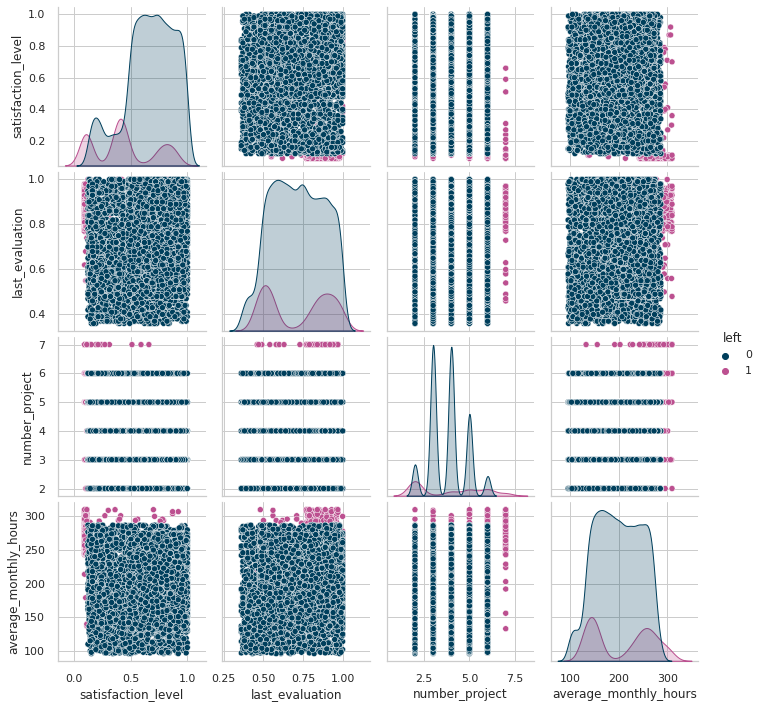

In [33]:
color_dict = {0: stayed_color, 1: left_color}

# pairplot 
sns.pairplot(df1, 
             hue='left', 
             vars=['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours'],
             palette=color_dict)

plt.show()

**Insights**
- <u>`average_monhtly_hours` x `satisfaction`</u>: Unlike the CoxPHFitter, the pairplot highlights a pattern in `average_monhtly_hours`. There's a cluster of employees who left with high working hours (around 250-300 monthly) and low satisfaction, indicating potential burnout issues.
<p></p>

- <u>`satisfaction_level`</u>: shows a clear bimodal distribution for employees who left (pink), with peaks at very low and high satisfaction, suggesting two distinct groups of leavers. Those who stayed (blue) generally have higher satisfaction.
<p></p>
- <u>`last_evaluation`</u>:  scores for those who left are concentrated at both extremes (very high or very low), while those who stayed have more evenly distributed scores.
<p></p>    
- <u>The number of projects</u>: employees with 2 or 7 projects are more likely to leave, suggesting both employees who aren't working on many projects and those who are working on a lot of projects are associated with turnover. The dynamic of the later group might be another signal of burnout. This is supported by the pairplot of `average_monthly_hours` against `number_project` where you see employees working long hours and a large number of projects leaving consistently.
<p></p>
- <u>`work_accident`</u>: as expected, also shows a significant relationship with turnover.


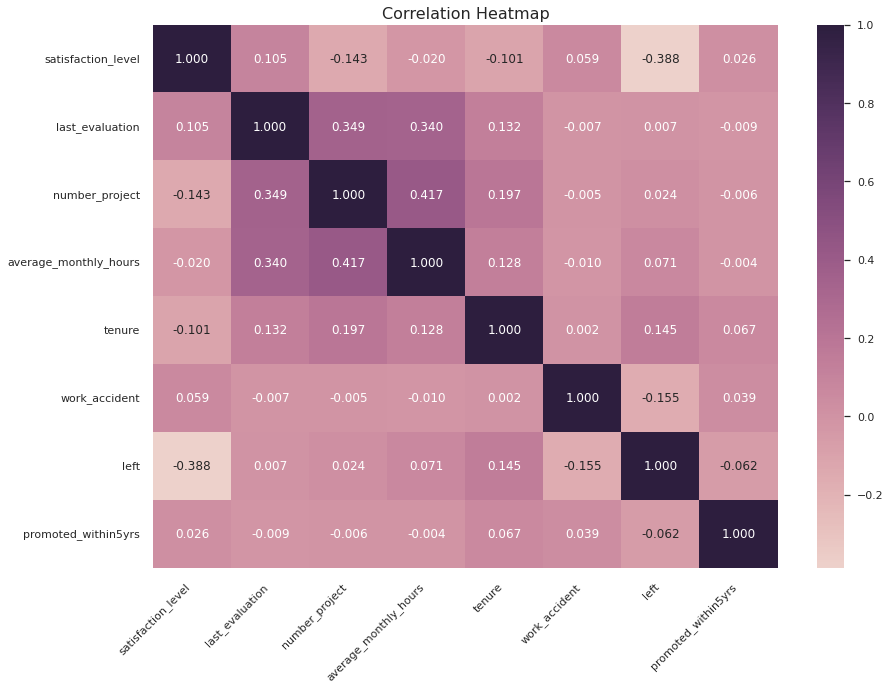

In [34]:
# create correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df0.corr().round(3), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.3f')
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

**Insights**:
- <u>`satisfaction_level`</u>: has the strongest negative correlation (-0.388) with 'left', indicating it's likely the most important factor in predicting turnover. Higher satisfaction is associated with lower likelihood of leaving.
<p></p>    
- <u>Unexpected insights</u>: surprisingly, `last_evaluation` and `number_projects` have very weak correlations with 'left' (0.007 and 0.024 respectively), suggesting they may not be as predictive of turnover as one might expect.
<p></p>    
- <u>Average monthly hours</u>: shows a slight positive correlation (0.071) with 'left', hinting that employees working longer hours might be somewhat more likely to leave
<p></p>    
- <u>Projects x hours</u>: There's a moderate positive correlation (0.417) between number of projects and average monthly hours, which could indicate a potential indirect effect on turnover through workload and what may have previously been behind what seemed like possible signs of burnout.
<p></p>    
    
These insights suggest that while satisfaction is clearly important, the relationships between variables and turnover are complex, and potentially non-linear. This is supported by some of the distributions shown previously.

# paCe: Construct Stage
### Pre-modeling considerations 
#### Model choice 
We implement a Random Forest and XGBoost to handle non-linearities and interactions. The downside of this is that the output doesnt easily lend itself to understanding why an employee leaves (eg feature importance does not translate into actionable business steps as easily). So we supplement the Tree-based analysis with a Cox model can also provide survival-based insights with easily interpretable coefficients
#### Which independent variables did you choose for the model and why?


#### Metric choice
While a 0.5 threshold is often used for classification we'd like a more robust metric in this case so we use ROC AUC. While recall and F1-score are useful for specific aspects of performance, like capturing true positives and balancing false positives/negatives respectively, ROC AUC gives a holistic measure of model quality that is crucial for ranking employees by turnover risk, handling class imbalance, and understanding model discrimination power without being affected by threshold selection.

Strategically, this ROC AUC optimizes for Saliforts business needs of prioritizing and effectively targing employee retention efforts.

### Feature engineering and interaction features
We've previously created `tenure_group` for feature engineering (see above). Next we'll combine `satisfaction_level` and `average_monthly_hours` to create an interaction feature `satisfaction_hours_interaction` which may capture the compunded effect of dissatisfaction and overwork

In [59]:
# replace satisfaction and average monthly hours with an interaction feature
df1['satisfaction_hours_interaction'] = df1['satisfaction_level'] * df1['average_monthly_hours']

In [60]:
# split the data and drop tenure as its captured by tenure groups
X = df1.drop(columns=['left', 'tenure'])
y = df1['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [61]:
# preprocessing for numeric and categorical columns
numeric_features = ['last_evaluation', 'number_project', 'satisfaction_hours_interaction']
categorical_features = ['salary', 'department', 'tenure_group', 'work_accident', 'promoted_within5yrs']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Step 3. Model Building, Step 4. Results and Evaluation

### Baseline models

First, we run the Cox PH model, which is specifically designed for survival analysis, which deals with time-to-event data. In Salifort's context, the "event" is an employee leaving the company or `left`=1, and "time" is their `tenure`. Why did we choose it and how dow we use it?:

- <u>Accounts for Censoring</u>: It properly handles _censored data_, such as employees who are still with the company at the end of the observation period.
- <u>Hazard Function (exp(coef)</u>: The model estimates the hazard rate with a ratio. Values below 1 decrease risk and those above 1 increase risk. This in Salifort's case represents the instantaneous risk of an employee leaving at a given time, conditional on survival until that time.
- <u>Supports time-varying covariates</u>: By modeling the hazard of leaving over time, we gain insights not just into whether employees leave, but when they are most at risk of leaving
- <u>Significant Predictors</u>: provides confidence intervals and features with low pvalues are statistically significant predictors of turnover
- <u>Effect Size</u>: The magnitude of the hazard ratios indicates the strength of each predictor

In [38]:
from lifelines import CoxPHFitter

# Select relevant covariates
covariates = ['satisfaction_level', 'average_monthly_hours', 'number_project', 'salary', 'department']

# encode categorical variables
df_encoded = pd.get_dummies(df1[covariates + ['tenure', 'left']], drop_first=True)

# fit the CoxPH model
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col='tenure', event_col='left')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11991 total observations, 10000 right-censored observations>
             duration col = 'tenure'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 11991
number of events observed = 1991
   partial log-likelihood = -16011.48
         time fit was run = 2024-10-21 13:56:04 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
satisfaction_level      -2.44       0.09       0.09            -2.61            -2.26                 0.07                 0.10
average_monthly_hours    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
number_project          -0.29       0.75       0.02            -0.32            -0.25                 0.72                 0.78
salary_low               1.53       4.64       0.15             1.24             1.83                 3.46                 6.20
salary_medium            1.15       3.17       0.15             0.86             1.45                 2.37                 4.26
department_RandD        -0.33       0.72       0.13            -0.60            -0.07                 0.55                 0.93
department_accounting   -0.02       0.98       0.12            -0.27             0.22                 0.76                 1.25
department_hr            0.14       1.14       0.12            -0.11             0.38                 0.90                 1.46
department_management   -0.18       0.84       0.16            -0.49             0.14                 0.61                 1.15
department_marketing     0.04       1.04       0.12            -0.20             0.28                 0.81                 1.32
department_product_mng   0.08       1.08       0.12            -0.17             0.32                 0.85                 1.38
department_sales         0.07       1.07       0.09            -0.11             0.25                 0.90                 1.28
department_support       0.14       1.15       0.10            -0.05             0.33                 0.95                 1.39
department_technical     0.15       1.16       0.09            -0.04             0.33                 0.96                 1.39

                         cmp to      z      p   -log2(p)
covariate                                               
satisfaction_level         0.00 -27.18 <0.005     538.09
average_monthly_hours      0.00   4.39 <0.005      16.43
number_project             0.00 -15.00 <0.005     166.55
salary_low                 0.00  10.31 <0.005      80.34
salary_medium              0.00   7.70 <0.005      46.09
department_RandD           0.00  -2.48   0.01       6.24
department_accounting      0.00  -0.20   0.84       0.25
department_hr              0.00   1.10   0.27       1.87
department_management      0.00  -1.09   0.28       1.86
department_marketing       0.00   0.30   0.76       0.39
department_product_mng     0.00   0.63   0.53       0.91
department_sales           0.00   0.78   0.43       1.20
department_support         0.00   1.42   0.16       2.69
department_technical       0.00   1.54   0.12       3.03
---
Concordance = 0.84
Partial AIC = 32050.95
log-likelihood ratio test = 1106.10 on 14 df
-log2(p) of ll-ratio test = 752.69

**Insights**
- <u>`satisfaction_level`</u>: The -2.44 coefficient indicates a strong negative effect on the risk of employees leaving, as we would imagine. The satisfaction_level's exp(coef), 0.09, means a one unit increase in satisfaction reduces the hazard by 91% (1 - 0.09), which kind of makes sense as 1 would indcate they are satified. But thats not helpful. So lets look at a more practical increase in satisfaction like 0.1. First we calculate the effect: 0.09^0.1 ≈ 0.79. In other words for a 0.1 increase in satisfaction_level on the 0-1 scale, the hazard of an employee leaving decreases by approximately 21% (1 - 0.79).
<p></p>
- <u>R&D Department</u>: Most variables are statistically significant (p < 0.005), except for the department variables, with the exception of R&D which, with a pvalue of 0.01 is significant at the 1% level. Salifort should pay attention to the unique needs or characteristics of the R&D workforce that might be driving down their turnover rate and should consider if any practices or policies from the R&D department can be applied to other departments to improve overall retention.
<p></p>
- <u>Number of projects</u>: Number of projects have a negative effect implying more projects slightly reduces risk of leaving.
<p></p>
- <u>Salary</u>: Low and medium salaries increase risk compared to high salaries. This implies competitive salaries, especially for low and medium brackets, are important.

Note while the `average_monthly_hours` has no effect size it could be that the relationship is nonlinear

Now that we have statistical insight into why employees leave, we turn to a Random Forest model to try to predict whether they leave.

In [62]:
# define a Random Forest model with pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# fit 
rf_pipeline.fit(X_train, y_train)

# predictions 
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3001
           1       0.96      0.90      0.93       597

    accuracy                           0.98      3598
   macro avg       0.97      0.95      0.96      3598
weighted avg       0.98      0.98      0.98      3598

Random Forest ROC AUC Score: 0.9691917322924742


The performance of all scores look suspiciously high and are in some cases perfect, hinting that there might be data leakage. To investigate, lets first look at the feature importance driving the Random Classifier's results.

         Random Forest Confusion Matrix:
         


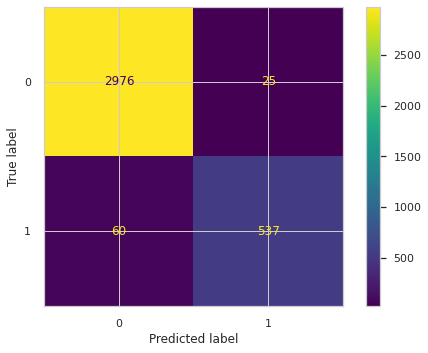

In [63]:
print("Random Forest Confusion Matrix:\n".center(50)) 
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, 
                                       display_labels=rf_pipeline.named_steps['classifier'].classes_)
rf_cm_display.plot(values_format='')
plt.show()

The confusion matrix shows a very good prediction of the employees who stayed, with only 25 false positives. There are 60 false negatives. 

In [64]:
# extract feature importances from RF
rf_classifier = rf_pipeline.named_steps['classifier']
feature_importances = rf_classifier.feature_importances_

# retrieve feature names after transformation
numeric_feature_names = numeric_features
categorical_feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
feature_names = numeric_feature_names + list(categorical_feature_names)

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,satisfaction_hours_interaction,0.378908
1,number_project,0.233624
0,last_evaluation,0.177562
15,tenure_group_4-6,0.106645
14,tenure_group_2-4,0.044793
17,work_accident_1,0.012709
3,salary_low,0.008257
11,department_sales,0.005306
4,salary_medium,0.004986
12,department_support,0.004921


`satisfaction_hours_interaction` might still be capturing too much of the `satisfaction_level` signal, which might inherently predict whether an employee leaves. Due its dominance in feature importance, this interaction might still be too informative, potentially leading to data leakage. 

So we'll try removing `satisfaction_hours_interaction` from our next Decision Tree based model. 

But first, lets revisit the PHCoxFitter.

### Revised and tuned models

**Handling Outliers for the CoxPHFitter** <br>
You'll recall the `satisfaction_level` -2.44 coefficient indicates 0.1 an increase in satisfaction_level on the 0-1 scale, implied the hazard of an employee leaving decreases by approximately 21% (1 - 0.79).
<p></p>

Given this is a crucial insight into why employees leave we should make sure its plausible. 

The Cox model partial likelihood approach might provide some robustness to outliers in the time dimension because it uses the ordering of events (and partial likelihood approach) rather than their exact timing but this advantage to logistic regression is often marginal. Outliers in the covariates can still be problematic for both models. So we should handle outliers.

You'll recall (see **Check Outliers**) there's a significant numbers of outliers in `satisfaction_level` (210), `last_evaluation` (107), and especially `tenure` (824). So we should consider handling outliers based on their nature: <br>
a) For `satisfaction_level` and `last_evaluation` which are bounded variables (0-1) the detected outliers are likely valid extreme values rather than errors. One approach is to winsorize them capping them to the 1st and 99th percentiles. 

That said, satisfaction has a relatively high correlation with left and we don't want to lose that signal. So instead we will keep the original values, including the 0s and 1, and bin these variables below, allowing us to keep the extremes while potentially capturing non-linear effects. Alternatively, we couldve applied a logit transformation like (eg lox(x/1-x)) but that would require handling 0s and 1s separately. 

So we bin them before re-analyzing below. 

b) For `tenure` the 824 outliers suggests a highly skewed distribution. We can log transform them to handle the outliers but CoxPHFitter conveniently already provides a log2(p) column for that interpretation. 

Alternatively, we can calculate the number of tenure outliers that leave and see how it will impact our analysis...

In [114]:
def extract_tenure_outliers_left(df1, outlier_results):
    tenure_bounds = outlier_results.loc['tenure']
    lower_bound, upper_bound = tenure_bounds['Lower Bound'], tenure_bounds['Upper Bound']
    
    tenure_outliers = df1[(df1['tenure'] < lower_bound) | (df1['tenure'] > upper_bound)]
    tenure_outliers_left = tenure_outliers[tenure_outliers['left'] == 1]
    
    return tenure_outliers_left

outlier_results = outlier_detection(df1)

tenure_outliers_left = extract_tenure_outliers_left(df1, outlier_results)

print(f"Number of tenure outliers that left: {len(tenure_outliers_left)}")

total_left = df1['left'].sum()

# calculate % of tenure outliers that left out of all employees who left
percentage_outliers_of_left = (len(tenure_outliers_left) / total_left) * 100

print(f"\nTotal number of employees who left: {total_left}")
print(f"Percentage of tenure outliers among those who left: {percentage_outliers_of_left:.2f}%")

# compare with overall tenure outliers
all_tenure_outliers = df1[(df1['tenure'] < outlier_results.loc['tenure', 'Lower Bound']) | 
                         (df1['tenure'] > outlier_results.loc['tenure', 'Upper Bound'])]
print(f"\nTotal number of tenure outliers: {len(all_tenure_outliers)}")
print(f"Percentage of tenure outliers that left: {len(tenure_outliers_left) / len(all_tenure_outliers) * 100:.2f}%")


Number of tenure outliers that left: 109

Total number of employees who left: 1991
Percentage of tenure outliers among those who left: 5.47%

Total number of tenure outliers: 824
Percentage of tenure outliers that left: 13.23%


We can likely, safely remove the `tenure` outliers as that would only remove 109 of the 1991 that left, leaving 1,882 and 715 from the 10,000 that stayed leaving 9,285 for a total of 11,167 observations with a similar 17%-83% mix of left and stayed.

Next we'll remove `tenure` outliers, bin the `satisfaction_level` and `last_evaluation` as mentioned in step a). After handling outliers with these two steps we'll re-run the CoxPhFitter model.

In [119]:
def prepare_variables(df, outlier_results):
    # remove tenure outliers
    tenure_bounds = outlier_results.loc['tenure']
    lower_bound, upper_bound = tenure_bounds['Lower Bound'], tenure_bounds['Upper Bound']
    df = df[(df['tenure'] >= lower_bound) & (df['tenure'] <= upper_bound)]

    # bin satisfaction_level and last_evaluation
    df['satisfaction_bin'] = pd.cut(df['satisfaction_level'], 
                                    bins=[0, 0.2, 0.4, 0.6, 0.8, 1], 
                                    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    df['evaluation_bin'] = pd.cut(df['last_evaluation'], 
                                  bins=[0, 0.2, 0.4, 0.6, 0.8, 1], 
                                  labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    return df

# run outlier detection
outlier_results = outlier_detection(df1)

# apply variable preparation
df_prepared = prepare_variables(df1, outlier_results)

# update covariates list 
covariates = ['satisfaction_bin', 'evaluation_bin', 
              'average_monthly_hours', 'number_project', 'salary', 
              'department', 'tenure']

# encode categorical variables
df_encoded = pd.get_dummies(df_prepared[covariates + ['left']], drop_first=True)

# fit the CoxPH model
cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_encoded, duration_col='tenure', event_col='left')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11167 total observations, 9285 right-censored observations>
             duration col = 'tenure'
                event col = 'left'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11167
number of events observed = 1882
   partial log-likelihood = -14771.04
         time fit was run = 2024-10-21 18:20:40 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
average_monthly_hours        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
number_project              -0.12       0.88       0.02            -0.15            -0.09                 0.86                 0.91
satisfaction_bin_Low         0.36       1.43       0.05             0.25             0.46                 1.29                 1.59
satisfaction_bin_Medium      0.05       1.06       0.05            -0.04             0.15                 0.96                 1.16
satisfaction_bin_High       -0.59       0.55       0.05            -0.68            -0.50                 0.51                 0.61
satisfaction_bin_Very High  -0.54       0.58       0.05            -0.63            -0.45                 0.53                 0.64
evaluation_bin_Low          -0.99       0.37       0.17            -1.33            -0.65                 0.27                 0.52
evaluation_bin_Medium        0.50       1.64       0.05             0.40             0.59                 1.50                 1.80
evaluation_bin_High         -0.57       0.56       0.05            -0.67            -0.48                 0.51                 0.62
evaluation_bin_Very High     0.16       1.17       0.05             0.07             0.25                 1.07                 1.28
salary_low                   0.25       1.28       0.04             0.16             0.34                 1.18                 1.40
salary_medium               -0.00       1.00       0.04            -0.09             0.09                 0.92                 1.09
department_RandD            -0.19       0.82       0.08            -0.36            -0.03                 0.70                 0.97
department_accounting       -0.02       0.98       0.08            -0.18             0.14                 0.83                 1.15
department_hr                0.03       1.03       0.08            -0.13             0.20                 0.88                 1.22
department_management       -0.02       0.98       0.11            -0.24             0.20                 0.79                 1.22
department_marketing         0.03       1.03       0.08            -0.13             0.19                 0.88                 1.21
department_product_mng      -0.04       0.96       0.08            -0.20             0.12                 0.82                 1.13
department_sales             0.06       1.06       0.05            -0.03             0.15                 0.97                 1.16
department_support           0.02       1.02       0.05            -0.09             0.12                 0.91                 1.13
department_technical         0.03       1.03       0.05            -0.07             0.13                 0.93                 1.14

                             cmp to      z      p   -log2(p)
covariate                                                   
average_monthly_hours          0.00   2.88 <0.005       7.98
number_project                 0.00  -7.89 <0.005      48.23
satisfaction_bin_Low           0.00   6.59 <0.005      34.37
satisfaction_bin_Medium        0.00   1.15   0.25       2.00
satisfaction_bin_High          0.00 -12.65 <0.005     119.38
satisfaction_bin_Very High     0.00 -11.57 <0.005     100.43
evaluation_bin_Low             0.00  -5.77 <0

**Insights**:
- <u>Model improvement</u>: The revised model shows a higher concordance (0.87 vs 0.84), indicating better predictive performance.
<p></p>    
- <u>Satisfaction level</u>: Employee satisfaction remains the most crucial factor in predicting turnover, but the binned version provides more nuanced insights into its non-linear effects. Low satisfaction exp(coef) = 1.43) increases turnover risk by 43% compared to the category.High (exp(coef) = 0.55) and Very High satisfaction (exp(coef) = 0.58) significantly decrease turnover risk, by 45% and 42% respectively.This non-linear effect wasn't captured in the previous model.
<p></p>    
- <u>Evaluations</u>: Surprisingly, medium evaluations (exp(coef) = 1.64) increase turnover risk by 64%. This may be due to employees feeling underappreciated or a disconnect between their take on performance vs. that of management. Low evaluations (exp(coef) = 0.37) decrease turnover risk by 63% for some reason. High evaluations (exp(coef) = 0.56) decrease turnover risk by 44% (1 - 0.56 = 0.44 or 44%). 
<p></p>    
- <u>Projects</u>: Number of projects (exp(coef) = 0.88) decreases turnover risk by 12% but the effect is less pronounced than in the previous model.
<p></p> 
- <u>Salary</u>: Low salary (exp(coef) = 1.28) increases turnover risk by 28%.
<p></p> 
- <u>Departments</u>: Department effects are generally less pronounced in the new model, with only R&D department (exp(coef) = 0.82) decreases turnover risk by 18% (1 - 0.82 = 0.18 or 18%).
<p></p>    

**XGBoost Optuna tuned model** <br>
Next we use Optuna to tune a XGBoost model that excludes `satisfaction_hours_interaction` to avoid the overfitting that occured in the baseline RandomForest model.

In [53]:
# split the data and drop tenure as its captured by tenure groups
X = df1.drop(columns=['left', 'tenure', 'satisfaction_hours_interaction'])
y = df1['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [54]:
# preprocessing for numeric and categorical columns
numeric_features = ['last_evaluation', 'number_project']
categorical_features = ['salary', 'department', 'tenure_group', 'work_accident', 'promoted_within5yrs']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [44]:
param_distributions = {
    'classifier__n_estimators': IntDistribution(low=100, high=500),
    'classifier__max_depth': IntDistribution(low=3, high=10),
    'classifier__learning_rate': FloatDistribution(low=0.01, high=0.3),
    'classifier__min_child_weight': IntDistribution(low=1, high=10),
    'classifier__gamma': FloatDistribution(low=0, high=0.5),
    'classifier__subsample': FloatDistribution(low=0.5, high=1.0),
    'classifier__colsample_bytree': FloatDistribution(low=0.5, high=1.0),
    'classifier__reg_alpha': FloatDistribution(low=0, high=1),
    'classifier__reg_lambda': FloatDistribution(low=0, high=1),
}

# initialize the XGB model within a pipeline 
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        random_state=43,
        eval_metric='logloss',
        n_jobs=-1  
    ))
])

# set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

# set up OptunaSearchCV for XGBoost
optuna_search = optuna.integration.OptunaSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    cv=skf,
    scoring='roc_auc',  
    n_jobs=-1,
    n_trials=100,
    random_state=43
)

# fit 
start_time = time.time()
optuna_search.fit(X_train, y_train)
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime: {total_time / 60:.2f} minutes")

# save the optimized model
path = '/home/jovyan/work/'
with open(path + 'cv_optuna_search.pickle', 'wb') as to_write:
    pickle.dump(optuna_search, to_write)
    

Total runtime: 52.62 minutes


In [73]:
# open pickled optuna model
with open('cv_optuna_search.pickle', 'rb') as to_read:
    cv_optuna_search = pickle.load(to_read)

In [95]:
# print results
print("XGBoost Optuna Model Feature Importances")
print()

best_pipeline = optuna_search.best_estimator_

# extract the XGBClassifier from the pipeline
best_classifier = best_pipeline.named_steps['classifier']

feature_to_remove = 'satisfaction_hours_interaction'
feature_names = [feature for feature in feature_names if feature != feature_to_remove]

assert len(feature_names) == len(importances), "Feature names and importances lengths do not match!"

# create DataFrame for feature importances
feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_imp

XGBoost Optuna Model Feature Importances



,Feature,Importance
0,number_project,0.263870
1,tenure_group_4-6,0.209952
2,tenure_group_2-4,0.163591
3,last_evaluation,0.124361
4,work_accident_1,0.048814
5,salary_medium,0.040191
6,salary_low,0.026713
7,tenure_group_6+,0.023048
8,promoted_within5yrs_1,0.018200
9,department_hr,0.016616


The model focuses more on features like `number_project`, `tenure_group_4-6`, and `tenure_group_2-4`. The importance values are distributed more evenly, suggesting less reliance on the potentially problematic `satisfaction_hours_interaction` feature, which may have caused overfitting in the RandomForest model.

            XGBoost Confusion Matrix:
            


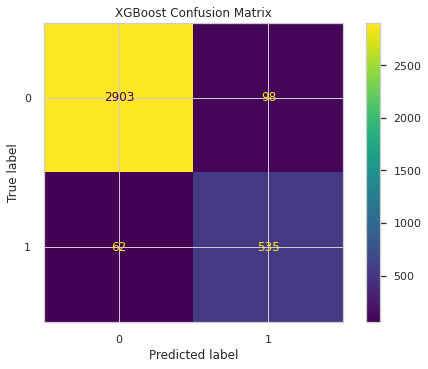

In [97]:
print("XGBoost Confusion Matrix:\n".center(50))

# use the best_pipeline to transform X_test
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# get preds using the transformed X_test
y_pred_xgb = best_classifier.predict(X_test_transformed)

# confusion matrix for XGBoost
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, 
                                        display_labels=best_classifier.classes_)
xgb_cm_display.plot(values_format='')
plt.title("XGBoost Confusion Matrix")
plt.show()

This model has more false positives compared to RandomForest (98 vs. 25) but maintains similar false negatives (62 vs. 60). The increase in false positives might be related to the fact that the model is not using `satisfaction_hours_interaction` and is instead making predictions with less potential bias or overfitting.

In [67]:
X_test_rf = X_test.copy()  
X_test_xgb = X_test.drop(columns=['satisfaction_hours_interaction']) 

# Define models dictionary with different test sets for evaluation
models = {
    'RandomForest_Baseline': (rf_pipeline),
    'XGBoost_Optuna': (optuna_search.best_estimator_)
}


In [101]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_score = roc_auc_score(y, y_pred_proba)

    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC AUC': auc_score
    }

results = []

for name, model in models.items():
    val_results = evaluate_model(model, X_test, y_test)
    results.append({'Model': name, **val_results})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC AUC', ascending=False)

# formatting
float_columns = ['Precision', 'Recall', 'F1-score', 'ROC AUC']
for col in float_columns:
    results_df[col] = results_df[col].map('{:.6f}'.format)

results_list = results_df.values.tolist()
results_headers = results_df.columns.tolist()

table = tabulate(results_list, headers=results_headers, tablefmt='rounded_grid', numalign="right", stralign="left")
print(table)

╭───────────────────────┬────────────┬─────────────┬──────────┬────────────┬───────────╮
│ Model                 │   Accuracy │   Precision │   Recall │   F1-score │   ROC AUC │
├───────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ RandomForest_Baseline │   0.976376 │    0.955516 │ 0.899497 │   0.926661 │  0.969192 │
├───────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ XGBoost_Optuna        │   0.955531 │    0.845182 │ 0.896147 │   0.869919 │  0.961408 │
╰───────────────────────┴────────────┴─────────────┴──────────┴────────────┴───────────╯


The XGBoost Optuna-tuned model, although slightly weaker in performance metrics, was trained on a more robust set of features, likely making it better for unseen data and generalizability.

# pacE: Execute Stage
- Model performance and results
- Actionable steps 

## Step 4. Results and Evaluation

### Summary of model results

- <u>Top Predictors of Turnover</u>: The most important features contributing to employee turnover in the XGBoost model were `number of projects`, the tenure groupings, and `last evaluation`. These features provide insights into how workload, tenure, and performance evaluations correlate with an employee's decision to leave.
<p></p>
- <u>Feature Leakage and Generalizability</u>: The feature `satisfaction_level`  showed very high importance in the RandomForest model even when converted to an interaction term as `satisfaction_hours_interaction` indicating potential data leakage. Removing it led to a slightly weaker XGBoost model but one that is likely more generalizable and robust for predicting turnover on new data.
<p></p>
- <u>Model Comparison</u>: While the RandomForest model showed slightly better metrics in accuracy and precision, the XGBoost model was selected as the champion model due to its robustness and generalizability. The XGBoost model still performed well with a >96% ROC AUC, indicating strong discriminatory power between classes without relying on a potentially biased feature. That said we should continue to check for data leakage as the score seems suspiciously high for a real-world data set.
<p></p>
- <u>Survival Analysis Insights</u>: The Cox Proportional Hazards model provided complementary insights into turnover risk. Key findings indicated that employees in the 2-4 year and 4-6 year tenure groups have a significantly higher hazard rate of turnover compared to other cohorts. This reinforces the importance of focusing retention efforts during these critical tenure periods to mitigate turnover risk. Equally important it provides coefficients that can be used as KPIs to achieve objectives related to redudincg turnover.
<p></p>

### Conclusion, Recommendations, Next Steps

- <u>Actionable Business Insights</u>: Employees with high workloads (number of projects) and those within certain tenure groups (2-4 years, 4-6 years) are at higher risk of turnover. 
    - **General**: Once Salifort is comfortable with where the CoxPH model is, they should consider the coefficients from the model to establish quantitative OKRs relatated to reducing turnover. For instance, a 0.2 increase in satisfaction amongst the "Medium" group effectively moving them to "High" satisfaction reduces turnover amogst this group by about 48% (1 - 0.55/1.06) and a 0.1 increase in satisfaction in that group might reduce turnover by ~24% (this assumes its the only variable at play which it likely isnt. nevertheless its informative as satisfaction typically incorporates a few aspects of the job).
    - **Workload**: Management should be provided with clear insight on employee workloads as lack of visibility may lead to the most talented being assigned to do more and eventually burning out. Surveys should be conducted to understand why certain employees are working considerably more. If its not due to over-assignment it might be due to a misunderstanding of the promotion or salary increase policy. More clarity on both might lead employees to work smarter not just harder. 
    - **Salary adjustments**: could be a key lever to improve retention, particularly for mid-tenure employees with lower compensation as lower-paid employees far more likely to leave. Introducing salary reviews or increases after 2-4 years could help address the turnover among this group.
    - **Promotions**: Promotion opportunities are crucial for retention, particularly for mid- to late-tenure employees. Salifort should implement programs to ensure promotion equity. For instance, employees that have stayed for over 6 years are 5x more likely to be promoted (11%). Salifort should consider smaller more frequent promotions for employees in the 2-6 year cohorts
    - **Safety protocols**: improving safetey and providing additional support for employees who have experienced accidents could help reduce turnover as work accidents 
    - **Department analysis**: Mid-tenure employees in high-turnover departments like sales and support should be a focus for retention efforts. Further, an assessment should be done on departments like R&D and HR to better understand mid-tenure employees are somewhat less likely to leave those groups.  
<p></p>
- <u>Further Questions</u>: The data suggests that workload, tenure, and evaluations significantly impact turnover, but deeper analysis is needed to understand how factors like salary, department roles, and work accidents interact with satisfaction. Running more detailed interaction segmentation on these features could yield actionable insights for specific departments or roles.
<p></p>
- <u>Survival Analysis Insights</u>: The Cox Proportional Hazards model provided complementary insights into turnover risk. Key findings indicated that employees in the 2-4 year and 4-6 year tenure groups have a significantly higher hazard rate of turnover compared to other cohorts. This reinforces the importance of focusing retention efforts during these critical tenure periods to mitigate turnover risk
<p></p>

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.